In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader,TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision
import time
from torch.nn import init
from thop import profile


In [2]:
# Remember to install CUDA and cuDNN
# Determine if your system supports CUDA.
device = 'cuda' if torch.cuda.is_available() else 'cpu'  
#%% Read data
data=pd.read_hdf("D:/conda/FallAllD.h5") #
data = data.drop(columns = ['Gyr','Mag','Bar'])
#%% Label
data_waist = []
label_waist = []
subject_waist = []
PATH = "D:/conda/111_1117/FullAll_3LayerModel_CNNSmall.pt"
for i in range(len(data)):
    if(data['Device'][i] == 'Waist'):
        a = data['Acc'][i]*0.000244
        # Normalize each data between 0 and 1
        b = b = (a-np.amin(a))/(np.amax(a)-np.amin(a)) 
        data_waist.append(b) 
        subject_waist.append(data['SubjectID'][i])
        # Class: fall = 0 ,ADL = 1 
        if (data['ActivityID'][i] > 100): 
            label_waist.append(1)
        else:
            label_waist.append(0)

# Change list to array
data_waist = np.array(data_waist)            
label_waist = np.array(label_waist)
subject_waist = np.array(subject_waist)

# Downsampling 1/128
down_data = []
# (start:size:step)
down_data = data_waist[::1,::128,::1]           
#%% Sliding_window
sliding_waist_data =[]
sliding_waist_label =[]
sliding_waist_subject =[]   

# The signal of each second 
per_sec = 38/20
sec = 7

In [3]:
for num in range(len(down_data)):
    if label_waist[num] ==1:
        # Data[index][start:end,axis]
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5)+1),:])
        # Label each window with class and subject
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        
    else:
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        
sliding_waist_data = np.array(sliding_waist_data)
sliding_waist_label = np.array(sliding_waist_label)
sliding_waist_subject = np.array(sliding_waist_subject) 

np.save('FallALLD_SW_data',sliding_waist_data)
np.save('FallALLD_SW_label',sliding_waist_label)
np.save('FallALLD_SW_subject',sliding_waist_subject)

In [4]:
#%% Show Teacher confusion matrix
def show_CM_teacher(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher) SubjectID' + str(sub) + '.png')

#%% Show Student confusion matrix
def show_CM_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Student) SubjectID' + str(sub) + '.png')
    
#%% Show Teacher-Student confusion matrix
def show_CM_teacher_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher-Student) SubjectID' + str(sub) + '.png')
def show_loss_teacher(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher) SubjectID' + str(sub) + '.png')
def show_Acc_teacher(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher) SubjectID' + str(sub) + '.png')
#Loss_student
def show_loss_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (Student) SubjectID' + str(sub) + '.png')   
def show_Acc_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (student) SubjectID' + str(sub) + '.png')
def show_loss_teacher_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher_Student) SubjectID' + str(sub) + '.png')   
def show_Acc_teacher_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher_student) SubjectID' + str(sub) + '.png')

In [5]:
def loss_fn_kd(outputs, labels, teacher_outputs, T=20, alpha=0.5):
    # 一般的Cross Entropy
    labels=labels.type(torch.cuda.LongTensor)
    hard_loss = F.cross_entropy(outputs, labels) * (1. - alpha)
    # 讓logits的log_softmax對目標機率(teacher的logits/T後softmax)做KL Divergence。
    soft_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T)
    return hard_loss + soft_loss

In [6]:
class hswish(nn.Module):
    def forward(self, x):
        out = x * F.relu6(x + 3, inplace=True) / 6
        return out


class hsigmoid(nn.Module):
    def forward(self, x):
        out = F.relu6(x + 3, inplace=True) / 6
        return out


class SeModule(nn.Module):
    def __init__(self, in_size, reduction=4):
        super(SeModule, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_size, in_size // reduction, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_size // reduction),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_size // reduction, in_size, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_size),
            hsigmoid()
        )

    def forward(self, x):
        return x * self.se(x)


class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, kernel_size, in_size, expand_size, out_size, nolinear, semodule, stride):
        super(Block, self).__init__()
        self.stride = stride
        self.se = semodule

        self.conv1 = nn.Conv2d(in_size, expand_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(expand_size)
        self.nolinear1 = nolinear
        self.conv2 = nn.Conv2d(expand_size, expand_size, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, groups=expand_size, bias=False)
        self.bn2 = nn.BatchNorm2d(expand_size)
        self.nolinear2 = nolinear
        self.conv3 = nn.Conv2d(expand_size, out_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_size)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_size != out_size:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_size, out_size, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_size),
            )

    def forward(self, x):
        out = self.nolinear1(self.bn1(self.conv1(x)))
        out = self.nolinear2(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.se != None:
            out = self.se(out)
        out = out + self.shortcut(x) if self.stride==1 else out
        return out

In [7]:
#%% This is the config object which contains all relevant settings.    
config = {
    'nb_filters': 64,
    'filter_width': 1,
    'drop_prob': 0.5,
    'epochs': 200,#200
    'batch_size': 64,
    'learning_rate': 1e-3,#1e-3
    'weight_decay': 2e-6,
    'gpu_name': 'cuda:0',
    'print_counts': False,
    'lr_factor' : 2,
    'lr_warmup' : 40
}

In [8]:
class MobileNetV3_Small(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Small, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), SeModule(16), 2),
            Block(3, 16, 72, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 88, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 96, 40, hswish(), SeModule(40), 2),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 120, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 144, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 288, 96, hswish(), SeModule(96), 2),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
        )


        self.conv2 = nn.Conv2d(96, 576, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(576)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(576, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

In [9]:
class MobileNetV3_Large(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Large, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), None, 1),
            Block(3, 16, 64, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 72, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 72, 40, nn.ReLU(inplace=True), SeModule(40), 2),
            Block(5, 40, 120, 40, nn.ReLU(inplace=True), SeModule(40), 1),
            Block(5, 40, 120, 40, nn.ReLU(inplace=True), SeModule(40), 1),
            Block(3, 40, 240, 80, hswish(), None, 2),
            Block(3, 80, 200, 80, hswish(), None, 1),
            Block(3, 80, 184, 80, hswish(), None, 1),
            Block(3, 80, 184, 80, hswish(), None, 1),
            Block(3, 80, 480, 112, hswish(), SeModule(112), 1),
            Block(3, 112, 672, 112, hswish(), SeModule(112), 1),
            Block(5, 112, 672, 160, hswish(), SeModule(160), 1),
            Block(5, 160, 672, 160, hswish(), SeModule(160), 2),
            Block(5, 160, 960, 160, hswish(), SeModule(160), 1),
        )


        self.conv2 = nn.Conv2d(160, 960, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(960)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(960, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

In [10]:
class MobileNetV3_Small_KD(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Small_KD, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), SeModule(16), 2),
            Block(3, 16, 72, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 88, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 96, 40, hswish(), SeModule(40), 2),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 120, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 144, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 288, 96, hswish(), SeModule(96), 2),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
        )


        self.conv2 = nn.Conv2d(96, 576, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(576)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(576, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

In [11]:
#%% Define teacher neural network
class block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
      super(block, self).__init__()
      self.expansion = 4
      self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn1 = nn.BatchNorm2d(out_channels)
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1,bias=False)
      self.bn2 = nn.BatchNorm2d(out_channels)
      self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
      self.relu = nn.ReLU()
      self.identity_downsample = identity_downsample
      self.stride = stride

  def forward(self, x):
      identity = x.clone()
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.bn3(x)

      if self.identity_downsample is not None:
          identity = self.identity_downsample(identity)

      x += identity
      x = self.relu(x)
      return x

class Net_Teacher(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

#%% Define student neural network
class Net_Student(nn.Module):
    def __init__(self,config): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Student, self).__init__()
        # Input hyperparameter 
        self.window_size = config['window_size']
        self.drop_prob = config['drop_prob']
        self.nb_channels = config['nb_channels']
        self.nb_classes = config['nb_classes']
        self.nb_filters = config['nb_filters']
        self.filter_width = config['filter_width']
        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(1, self.nb_filters, 3) 
        self.pool = nn.MaxPool2d([2,1])
        self.conv2 = nn.Conv2d(64, self.nb_filters,(3,1))
        
        # nn.Linear(input size,output size)
        self.fc1 = nn.Linear(64*4,256)  
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, 64)
        # In this case, we need to classify 2 classes, fall and ADL, so the last output size need to be 2
        self.fc4 = nn.Linear(64, 2)
         
    # Define forward propagation    
    def forward(self, x):  
        # Reshape input size (batch, input channels, window size, window channels)
        x = x.view(-1, 1, 14, 3) 
        x = F.relu(self.conv1(x)) 
        # output(64,64,12,1)
        x = self.pool(x)
        #(64,64,6,1)
        x = F.relu(self.conv2(x))
        #(64,64,4,1)
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x)) 
        x = self.fc4(x)
        
        return x    
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation

#%% Define student neural network
class Net_Teacher_Student(nn.Module):
    def __init__(self,config): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher_Student, self).__init__()
        # Input hyperparameter 
        self.window_size = config['window_size']
        self.drop_prob = config['drop_prob']
        self.nb_channels = config['nb_channels']
        self.nb_classes = config['nb_classes']
        self.nb_filters = config['nb_filters']
        self.filter_width = config['filter_width']
        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(1, self.nb_filters, 3) 
        self.pool = nn.MaxPool2d([2,1])
        self.conv2 = nn.Conv2d(64, self.nb_filters,(3,1))
        
        # nn.Linear(input size,output size)
        self.fc1 = nn.Linear(64*4,256)  
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, 64)
        # In this case, we need to classify 2 classes, fall and ADL, so the last output size need to be 2
        self.fc4 = nn.Linear(64, 2)
         
    # Define forward propagation    
    def forward(self, x):  
        # Reshape input size (batch, input channels, window size, window channels)
        x = x.view(-1, 1, 14, 3) 
        x = F.relu(self.conv1(x)) 
        # output(64,64,12,1)
        x = self.pool(x)
        #(64,64,6,1)
        x = F.relu(self.conv2(x))
        #(64,64,4,1)
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x)) 
        x = self.fc4(x)
        
        return x   
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation

In [12]:
class MobileNetV3_Small(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Small, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), SeModule(16), 2),
            Block(3, 16, 72, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 88, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 96, 40, hswish(), SeModule(40), 2),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 120, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 144, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 288, 96, hswish(), SeModule(96), 2),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
        )


        self.conv2 = nn.Conv2d(96, 576, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(576)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(576, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out


In [13]:
class MobileNetV3_Large(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Large, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), None, 1),
            Block(3, 16, 64, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 72, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 72, 40, nn.ReLU(inplace=True), SeModule(40), 2),
            Block(5, 40, 120, 40, nn.ReLU(inplace=True), SeModule(40), 1),
            Block(5, 40, 120, 40, nn.ReLU(inplace=True), SeModule(40), 1),
            Block(3, 40, 240, 80, hswish(), None, 2),
            Block(3, 80, 200, 80, hswish(), None, 1),
            Block(3, 80, 184, 80, hswish(), None, 1),
            Block(3, 80, 184, 80, hswish(), None, 1),
            Block(3, 80, 480, 112, hswish(), SeModule(112), 1),
            Block(3, 112, 672, 112, hswish(), SeModule(112), 1),
            Block(5, 112, 672, 160, hswish(), SeModule(160), 1),
            Block(5, 160, 672, 160, hswish(), SeModule(160), 2),
            Block(5, 160, 960, 160, hswish(), SeModule(160), 1),
        )


        self.conv2 = nn.Conv2d(160, 960, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(960)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(960, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

In [14]:
class MobileNetV3_Small_KD(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Small_KD, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), SeModule(16), 2),
            Block(3, 16, 72, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 88, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 96, 40, hswish(), SeModule(40), 2),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 120, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 144, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 288, 96, hswish(), SeModule(96), 2),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
        )


        self.conv2 = nn.Conv2d(96, 576, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(576)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(576, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

In [15]:
#%% Define teacher training loop
def training_teacher(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []

        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        train_acc.append(100 * (correct_train / total_train).cpu())
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
        
    eval_table = evaluation(train_preds, train_gt)

    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

#%% Define teacher testing loop
#def testing_teacher(testloader,optimizer,criterion,model):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)

                test_output = model(inputs)
                
                optimizer.zero_grad()

                # Compute loss
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step() 
                test_losses.append(loss.item())        
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)                

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher.append(eval_table[0])
#         Recall_teacher.append(eval_table[1])
#         Precision_teacher.append(eval_table[2])
#         F1score_teacher.append(eval_table[3])
    #Plot train_loss
        teacher_train_preds.extend(test_preds)
        teacher_train_gt.extend(test_gt)

    show_loss_teacher(loss_train, loss_test)
    show_Acc_teacher(train_acc, test_acc)
    #return Accuracy_teacher, Recall_teacher, Precision_teacher, F1score_teacher
    return teacher_train_preds, teacher_train_gt

In [16]:
#%% Define student training loop
def training_student(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(100 * (correct_train / total_train).cpu())
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval()
    #start_time = time.time()
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):            
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()                
                # Compute loss                

                test_output = model(inputs)
                
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step()
                test_losses.append(loss.item())                
                
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))
                
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
            elapsed = time.time() - start_time
            #print('| epoch {:3d} | {:5.4f} s/epoch | test loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))    
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nTest Val Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_student(test_gt, test_preds)
        #Store each result
#         Accuracy_student.append(eval_table[0])
#         Recall_student.append(eval_table[1])
#         Precision_student.append(eval_table[2])
#         F1score_student.append(eval_table[3])
        
        student_train_preds.extend(test_preds)
        student_train_gt.extend(test_gt)
    #Plot train_loss
    show_loss_student(loss_train, loss_test)
    show_Acc_student(train_acc, test_acc)
    
    #return Accuracy_student, Recall_student, Precision_student, F1score_student
    return student_train_preds, student_train_gt

In [17]:
def training_teacher_student(trainloader,optimizer,criterion,model_teacher,model_student,alpha,testloader,Layer,lis):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    total_num, total_hit = 0, 0
    # Freeze the Teacher model
    model_teacher.eval()
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds_student = []
        train_preds_teacher = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()

            # Forward pass (compute output)
            output_student = model_student(inputs)
            output_teacher = model_teacher(inputs)

            # Use softmax to normalize the output to a probability distribution over predicted output classes
            output_student_soft = F.softmax(output_student, dim =1)
            y_preds_student = np.argmax(output_student_soft.cpu().detach().numpy(), axis=-1)

            output_teacher_soft = F.softmax(output_teacher, dim =1)
            y_preds_teacher = np.argmax(output_teacher_soft.cpu().detach().numpy(), axis=-1)

            # Compute loss
            loss = loss_fn_kd(output_student, labels, output_teacher, 20, alpha)
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            total_hit += torch.sum(torch.argmax(output_student, dim=1) == labels).item()
            total_num += len(inputs)
            y_true = labels.cpu().numpy().flatten()
            train_preds_student = np.concatenate((np.array(train_preds_student, int), np.array(y_preds_student, int)))
            train_preds_teacher = np.concatenate((np.array(train_preds_teacher, int), np.array(y_preds_teacher, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(total_hit/total_num)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds_student, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')
    

#%% Define Teacher-Student testing loop
#def testing_teacher_student(testloader,optimizer,criterion,model_teacher,model_student):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_num, total_hit = 0, 0
    # Sets network to eval mod
    model_teacher.eval()
    model_student.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):            
            for i, (x, y) in enumerate(testloader):
                inputs ,targets = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                targets = targets.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()
                
                test_output = model_student(inputs)
                test_teacher = model_teacher(inputs)
                # Compute loss
                #loss = loss_fn_kd(test_output, labels, output_teacher, 20, alpha)                
                loss = loss_fn_kd(test_output, targets, test_teacher, 20, alpha)                
                # Backpropagaton
                #loss.backward() 
                # Update parameter
                #optimizer.step() 
                test_losses.append(loss.item())     
                
                test_output = F.softmax(test_output, dim=1)                
                total_hit += torch.sum(torch.argmax(test_output, dim=1) == targets).item()
                total_num += len(inputs)
                
                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = targets.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            #eval_table = evaluation(test_preds,test_gt)
            test_acc.append(total_hit/total_num)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher_student(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher_student.append(eval_table[0])
#         Recall_teacher_student.append(eval_table[1])
#         Precision_teacher_student.append(eval_table[2])
#         F1score_teacher_student.append(eval_table[3])      
        teacher_student_train_preds.extend(test_preds)
        teacher_student_train_gt.extend(test_gt)
    show_loss_teacher_student(loss_train, loss_test)
    show_Acc_teacher_student(train_acc,test_acc)
    #return Accuracy_teacher_student, Recall_teacher_student, Precision_teacher_student, F1score_teacher_student
    if (Layer==False) and (lis == 15):
            save(config['epochs'], model_student, optimizer, loss)  
            #return teacher_student_train_preds, teacher_student_train_gt, teacher_student_model, teacher_student_optimizer, teacher_student_loss
    if (Layer==False) and (lis == 1):
            save(config['epochs'], model_student, optimizer, loss)
    return teacher_student_train_preds, teacher_student_train_gt

In [18]:
def training_distillation_student(trainloader,optimizer,criterion,model_teacher,model_student,alpha,testloader,Layer,lis):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    total_num, total_hit = 0, 0
    # Freeze the Teacher model
    model_teacher.eval()
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds_student = []
        train_preds_teacher = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()

            # Forward pass (compute output)
            output_student = model_student(inputs)
            output_teacher = model_teacher(inputs)

            # Use softmax to normalize the output to a probability distribution over predicted output classes
            output_student_soft = F.softmax(output_student, dim =1)
            y_preds_student = np.argmax(output_student_soft.cpu().detach().numpy(), axis=-1)

            output_teacher_soft = F.softmax(output_teacher, dim =1)
            y_preds_teacher = np.argmax(output_teacher_soft.cpu().detach().numpy(), axis=-1)

            # Compute loss
            loss = loss_fn_kd(output_student, labels, output_teacher, 20, alpha)
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            total_hit += torch.sum(torch.argmax(output_student, dim=1) == labels).item()
            total_num += len(inputs)
            y_true = labels.cpu().numpy().flatten()
            train_preds_student = np.concatenate((np.array(train_preds_student, int), np.array(y_preds_student, int)))
            train_preds_teacher = np.concatenate((np.array(train_preds_teacher, int), np.array(y_preds_teacher, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(total_hit/total_num)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds_student, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')
    

#%% Define Teacher-Student testing loop
#def testing_teacher_student(testloader,optimizer,criterion,model_teacher,model_student):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_num, total_hit = 0, 0
    # Sets network to eval mod
    model_teacher.eval()
    model_student.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):            
            for i, (x, y) in enumerate(testloader):
                inputs ,targets = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                targets = targets.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()
                
                test_output = model_student(inputs)
                test_teacher = model_teacher(inputs)
                # Compute loss
                #loss = loss_fn_kd(test_output, labels, output_teacher, 20, alpha)                
                loss = loss_fn_kd(test_output, targets, test_teacher, 20, alpha)                
                # Backpropagaton
                #loss.backward() 
                # Update parameter
                #optimizer.step() 
                test_losses.append(loss.item())     
                
                test_output = F.softmax(test_output, dim=1)                
                total_hit += torch.sum(torch.argmax(test_output, dim=1) == targets).item()
                total_num += len(inputs)
                
                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = targets.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            #eval_table = evaluation(test_preds,test_gt)
            test_acc.append(total_hit/total_num)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher_student(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher_student.append(eval_table[0])
#         Recall_teacher_student.append(eval_table[1])
#         Precision_teacher_student.append(eval_table[2])
#         F1score_teacher_student.append(eval_table[3])      
        Distillation_student_train_preds.extend(test_preds)
        Distillation_student_train_gt.extend(test_gt)
    show_loss_teacher_student(loss_train, loss_test)
    show_Acc_teacher_student(train_acc,test_acc)
    #return Accuracy_teacher_student, Recall_teacher_student, Precision_teacher_student, F1score_teacher_student
    return Distillation_student_train_preds, Distillation_student_train_gt


In [19]:
def save(epoch, student, optimizer, loss):
#     trial_id = self.config['trial_id']
#     if name is None:
        torch.save({
        'epoch': epoch,
        'model_state_dict': student.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        #'loss_state_dict': loss.state_dice()
        'loss_state_dict': loss.item()
        }, PATH)
#     else:
#         torch.save({
#         'model_state_dict': self.student.state_dict(),
#         'optimizer_state_dict': self.optimizer.state_dict(),
#         'epoch': epoch,
#         }, name)

        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")

In [20]:
def load_checkpoint(model, checkpoint_path):
        """
        Loads weights from checkpoint
        :param model: a pytorch nn student
        :param str checkpoint_path: address/path of a file
        :return: pytorch nn student with weights loaded from checkpoint
        """
        model_ckp = torch.load(checkpoint_path)
        model.load_state_dict(model_ckp['model_state_dict'])
        return model
def evaluation(pred,target):
    acu = accuracy_score(pred, target)
    rec = recall_score(pred, target)
    pre = precision_score(pred, target)
    f1 = f1_score(pred, target)  
    return np.array([acu, rec, pre, f1])


Subject 1
| epoch   0 | 0.0938 s/epoch | train loss 0.4604
| epoch   1 | 0.0168 s/epoch | train loss 0.3557
| epoch   2 | 0.0169 s/epoch | train loss 0.3146
| epoch   3 | 0.0168 s/epoch | train loss 0.3060
| epoch   4 | 0.0168 s/epoch | train loss 0.3008
| epoch   5 | 0.0168 s/epoch | train loss 0.2930
| epoch   6 | 0.0169 s/epoch | train loss 0.2849
| epoch   7 | 0.0167 s/epoch | train loss 0.3338
| epoch   8 | 0.0167 s/epoch | train loss 0.3070
| epoch   9 | 0.0167 s/epoch | train loss 0.2706
| epoch  10 | 0.0168 s/epoch | train loss 0.2595
| epoch  11 | 0.0168 s/epoch | train loss 0.2629
| epoch  12 | 0.0168 s/epoch | train loss 0.2494
| epoch  13 | 0.0168 s/epoch | train loss 0.2328
| epoch  14 | 0.0169 s/epoch | train loss 0.2487
| epoch  15 | 0.0168 s/epoch | train loss 0.2474
| epoch  16 | 0.0167 s/epoch | train loss 0.2157
| epoch  17 | 0.0169 s/epoch | train loss 0.2136
| epoch  18 | 0.0175 s/epoch | train loss 0.2273
| epoch  19 | 0.0169 s/epoch | train loss 0.2081
| epoch  

| epoch 167 | 0.0174 s/epoch | train loss 0.0262
| epoch 168 | 0.0168 s/epoch | train loss 0.0225
| epoch 169 | 0.0169 s/epoch | train loss 0.0310
| epoch 170 | 0.0168 s/epoch | train loss 0.0257
| epoch 171 | 0.0171 s/epoch | train loss 0.0211
| epoch 172 | 0.0172 s/epoch | train loss 0.0428
| epoch 173 | 0.0172 s/epoch | train loss 0.0291
| epoch 174 | 0.0175 s/epoch | train loss 0.0339
| epoch 175 | 0.0169 s/epoch | train loss 0.0422
| epoch 176 | 0.0170 s/epoch | train loss 0.0714
| epoch 177 | 0.0174 s/epoch | train loss 0.0774
| epoch 178 | 0.0174 s/epoch | train loss 0.0363
| epoch 179 | 0.0177 s/epoch | train loss 0.0333
| epoch 180 | 0.0171 s/epoch | train loss 0.0471
| epoch 181 | 0.0168 s/epoch | train loss 0.0210
| epoch 182 | 0.0172 s/epoch | train loss 0.0332
| epoch 183 | 0.0173 s/epoch | train loss 0.0525
| epoch 184 | 0.0173 s/epoch | train loss 0.0224
| epoch 185 | 0.0171 s/epoch | train loss 0.0235
| epoch 186 | 0.0172 s/epoch | train loss 0.0225
| epoch 187 | 0.0172

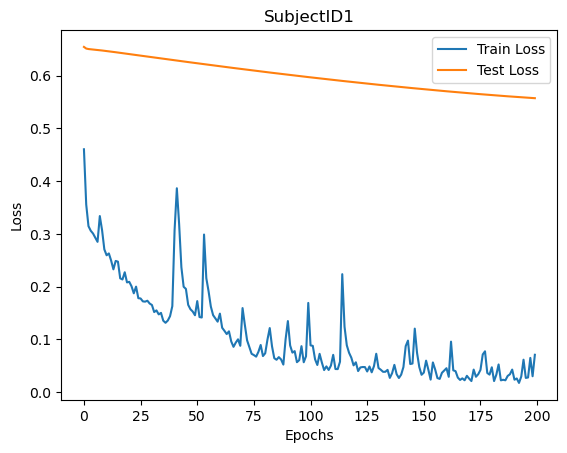

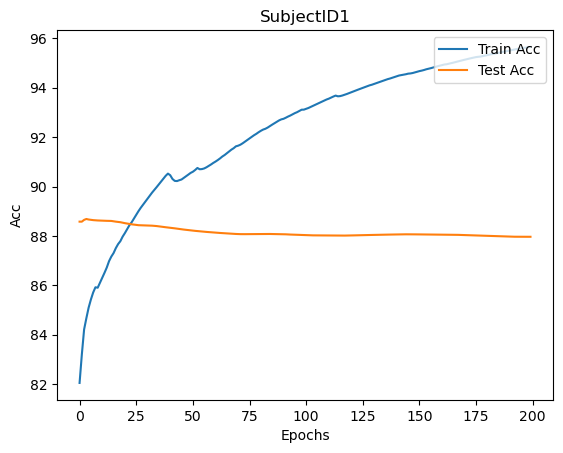

| epoch   0 | 0.0285 s/epoch | train loss 0.4393
| epoch   1 | 0.0268 s/epoch | train loss 0.3991
| epoch   2 | 0.0263 s/epoch | train loss 0.3865
| epoch   3 | 0.0266 s/epoch | train loss 0.3883
| epoch   4 | 0.0268 s/epoch | train loss 0.3727
| epoch   5 | 0.0267 s/epoch | train loss 0.3578
| epoch   6 | 0.0266 s/epoch | train loss 0.3454
| epoch   7 | 0.0266 s/epoch | train loss 0.3519
| epoch   8 | 0.0262 s/epoch | train loss 0.3536
| epoch   9 | 0.0266 s/epoch | train loss 0.3630
| epoch  10 | 0.0268 s/epoch | train loss 0.3550
| epoch  11 | 0.0266 s/epoch | train loss 0.3293
| epoch  12 | 0.0270 s/epoch | train loss 0.3252
| epoch  13 | 0.0272 s/epoch | train loss 0.3253
| epoch  14 | 0.0274 s/epoch | train loss 0.3167
| epoch  15 | 0.0284 s/epoch | train loss 0.3224
| epoch  16 | 0.0279 s/epoch | train loss 0.3697
| epoch  17 | 0.0283 s/epoch | train loss 0.3584
| epoch  18 | 0.0283 s/epoch | train loss 0.3416
| epoch  19 | 0.0276 s/epoch | train loss 0.3432
| epoch  20 | 0.0278

| epoch 168 | 0.0330 s/epoch | train loss 0.1000
| epoch 169 | 0.0330 s/epoch | train loss 0.1027
| epoch 170 | 0.0337 s/epoch | train loss 0.1048
| epoch 171 | 0.0329 s/epoch | train loss 0.0998
| epoch 172 | 0.0321 s/epoch | train loss 0.1132
| epoch 173 | 0.0343 s/epoch | train loss 0.0857
| epoch 174 | 0.0327 s/epoch | train loss 0.0975
| epoch 175 | 0.0324 s/epoch | train loss 0.0820
| epoch 176 | 0.0325 s/epoch | train loss 0.1002
| epoch 177 | 0.0321 s/epoch | train loss 0.0884
| epoch 178 | 0.0329 s/epoch | train loss 0.0884
| epoch 179 | 0.0321 s/epoch | train loss 0.1059
| epoch 180 | 0.0327 s/epoch | train loss 0.1053
| epoch 181 | 0.0317 s/epoch | train loss 0.0901
| epoch 182 | 0.0343 s/epoch | train loss 0.0900
| epoch 183 | 0.0335 s/epoch | train loss 0.0799
| epoch 184 | 0.0328 s/epoch | train loss 0.0878
| epoch 185 | 0.0334 s/epoch | train loss 0.0868
| epoch 186 | 0.0330 s/epoch | train loss 0.1025
| epoch 187 | 0.0333 s/epoch | train loss 0.0887
| epoch 188 | 0.0328

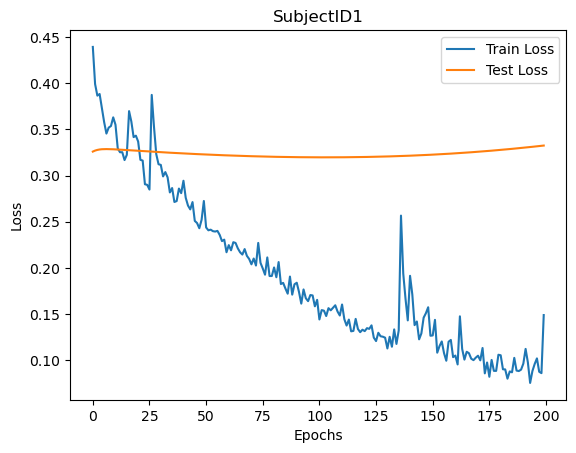

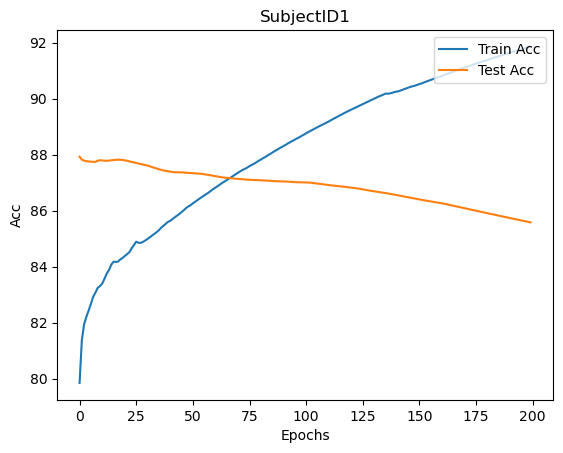


Subject 2
| epoch   0 | 0.0293 s/epoch | train loss 0.4850
| epoch   1 | 0.0286 s/epoch | train loss 0.3973
| epoch   2 | 0.0292 s/epoch | train loss 0.3587
| epoch   3 | 0.0293 s/epoch | train loss 0.3203
| epoch   4 | 0.0292 s/epoch | train loss 0.3178
| epoch   5 | 0.0292 s/epoch | train loss 0.2927
| epoch   6 | 0.0290 s/epoch | train loss 0.2929
| epoch   7 | 0.0290 s/epoch | train loss 0.3869
| epoch   8 | 0.0292 s/epoch | train loss 0.3171
| epoch   9 | 0.0294 s/epoch | train loss 0.3153
| epoch  10 | 0.0293 s/epoch | train loss 0.3518
| epoch  11 | 0.0296 s/epoch | train loss 0.3190
| epoch  12 | 0.0291 s/epoch | train loss 0.2892
| epoch  13 | 0.0290 s/epoch | train loss 0.2771
| epoch  14 | 0.0292 s/epoch | train loss 0.2656
| epoch  15 | 0.0287 s/epoch | train loss 0.2600
| epoch  16 | 0.0293 s/epoch | train loss 0.2627
| epoch  17 | 0.0290 s/epoch | train loss 0.2504
| epoch  18 | 0.0286 s/epoch | train loss 0.2695
| epoch  19 | 0.0291 s/epoch | train loss 0.2384
| epoch  

| epoch 167 | 0.0283 s/epoch | train loss 0.0538
| epoch 168 | 0.0279 s/epoch | train loss 0.0602
| epoch 169 | 0.0280 s/epoch | train loss 0.0743
| epoch 170 | 0.0279 s/epoch | train loss 0.0452
| epoch 171 | 0.0280 s/epoch | train loss 0.0642
| epoch 172 | 0.0282 s/epoch | train loss 0.0498
| epoch 173 | 0.0280 s/epoch | train loss 0.0464
| epoch 174 | 0.0282 s/epoch | train loss 0.0369
| epoch 175 | 0.0280 s/epoch | train loss 0.0817
| epoch 176 | 0.0278 s/epoch | train loss 0.0545
| epoch 177 | 0.0283 s/epoch | train loss 0.0731
| epoch 178 | 0.0285 s/epoch | train loss 0.0491
| epoch 179 | 0.0258 s/epoch | train loss 0.0545
| epoch 180 | 0.0275 s/epoch | train loss 0.0559
| epoch 181 | 0.0270 s/epoch | train loss 0.3589
| epoch 182 | 0.0272 s/epoch | train loss 0.2165
| epoch 183 | 0.0268 s/epoch | train loss 0.1709
| epoch 184 | 0.0266 s/epoch | train loss 0.1784
| epoch 185 | 0.0272 s/epoch | train loss 0.2473
| epoch 186 | 0.0261 s/epoch | train loss 0.1658
| epoch 187 | 0.0269

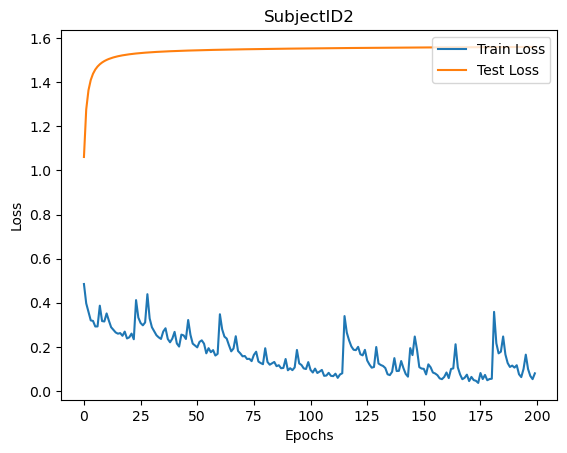

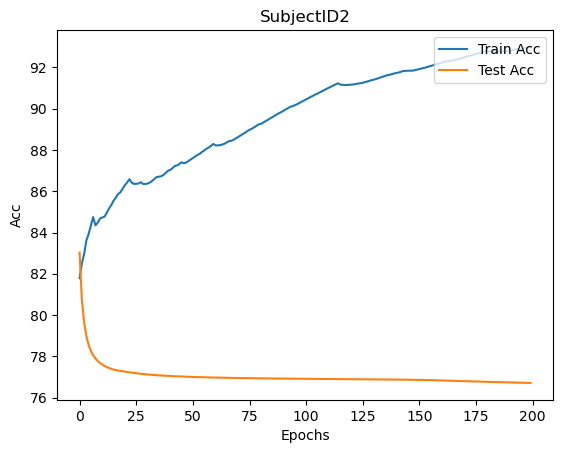

| epoch   0 | 0.0320 s/epoch | train loss 0.4760
| epoch   1 | 0.0320 s/epoch | train loss 0.4139
| epoch   2 | 0.0319 s/epoch | train loss 0.4009
| epoch   3 | 0.0322 s/epoch | train loss 0.4064
| epoch   4 | 0.0321 s/epoch | train loss 0.3933
| epoch   5 | 0.0325 s/epoch | train loss 0.3821
| epoch   6 | 0.0318 s/epoch | train loss 0.3883
| epoch   7 | 0.0330 s/epoch | train loss 0.3640
| epoch   8 | 0.0323 s/epoch | train loss 0.3538
| epoch   9 | 0.0327 s/epoch | train loss 0.3647
| epoch  10 | 0.0326 s/epoch | train loss 0.3604
| epoch  11 | 0.0324 s/epoch | train loss 0.3625
| epoch  12 | 0.0319 s/epoch | train loss 0.3676
| epoch  13 | 0.0324 s/epoch | train loss 0.3613
| epoch  14 | 0.0313 s/epoch | train loss 0.3540
| epoch  15 | 0.0328 s/epoch | train loss 0.3334
| epoch  16 | 0.0326 s/epoch | train loss 0.3310
| epoch  17 | 0.0327 s/epoch | train loss 0.3203
| epoch  18 | 0.0326 s/epoch | train loss 0.3148
| epoch  19 | 0.0314 s/epoch | train loss 0.3397
| epoch  20 | 0.0321

| epoch 168 | 0.0324 s/epoch | train loss 0.1491
| epoch 169 | 0.0323 s/epoch | train loss 0.1410
| epoch 170 | 0.0319 s/epoch | train loss 0.1289
| epoch 171 | 0.0311 s/epoch | train loss 0.1421
| epoch 172 | 0.0313 s/epoch | train loss 0.1255
| epoch 173 | 0.0328 s/epoch | train loss 0.1280
| epoch 174 | 0.0326 s/epoch | train loss 0.1466
| epoch 175 | 0.0318 s/epoch | train loss 0.2403
| epoch 176 | 0.0327 s/epoch | train loss 0.1815
| epoch 177 | 0.0318 s/epoch | train loss 0.1572
| epoch 178 | 0.0318 s/epoch | train loss 0.1460
| epoch 179 | 0.0324 s/epoch | train loss 0.1468
| epoch 180 | 0.0320 s/epoch | train loss 0.1311
| epoch 181 | 0.0329 s/epoch | train loss 0.1235
| epoch 182 | 0.0327 s/epoch | train loss 0.1264
| epoch 183 | 0.0322 s/epoch | train loss 0.1244
| epoch 184 | 0.0328 s/epoch | train loss 0.1255
| epoch 185 | 0.0316 s/epoch | train loss 0.1244
| epoch 186 | 0.0316 s/epoch | train loss 0.1289
| epoch 187 | 0.0315 s/epoch | train loss 0.1227
| epoch 188 | 0.0325

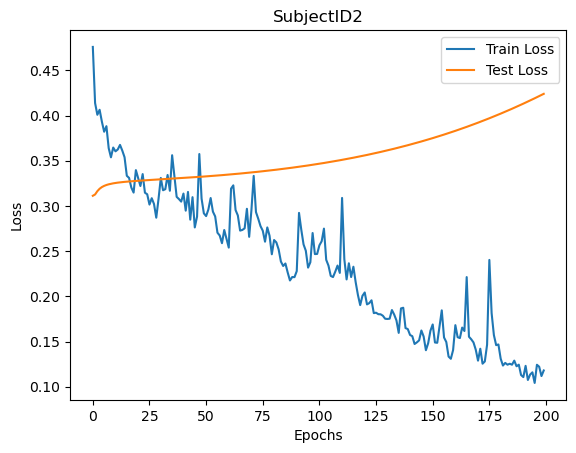

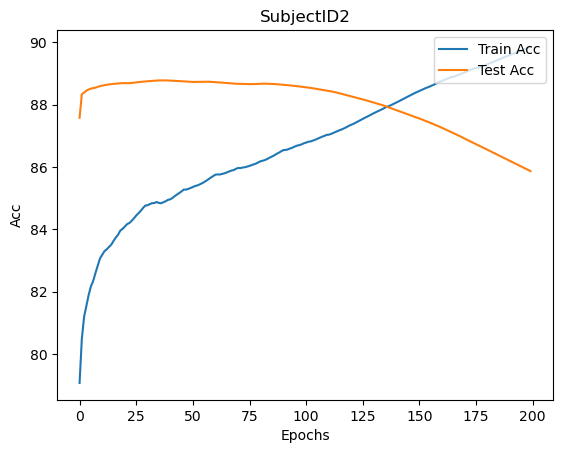


Subject 3
| epoch   0 | 0.0268 s/epoch | train loss 0.4184
| epoch   1 | 0.0268 s/epoch | train loss 0.3191
| epoch   2 | 0.0270 s/epoch | train loss 0.3036
| epoch   3 | 0.0270 s/epoch | train loss 0.2924
| epoch   4 | 0.0266 s/epoch | train loss 0.2752
| epoch   5 | 0.0267 s/epoch | train loss 0.2751
| epoch   6 | 0.0272 s/epoch | train loss 0.2740
| epoch   7 | 0.0274 s/epoch | train loss 0.2686
| epoch   8 | 0.0270 s/epoch | train loss 0.2929
| epoch   9 | 0.0271 s/epoch | train loss 0.2773
| epoch  10 | 0.0260 s/epoch | train loss 0.2460
| epoch  11 | 0.0269 s/epoch | train loss 0.2667
| epoch  12 | 0.0267 s/epoch | train loss 0.2520
| epoch  13 | 0.0267 s/epoch | train loss 0.2329
| epoch  14 | 0.0268 s/epoch | train loss 0.2432
| epoch  15 | 0.0271 s/epoch | train loss 0.2605
| epoch  16 | 0.0271 s/epoch | train loss 0.2367
| epoch  17 | 0.0269 s/epoch | train loss 0.2174
| epoch  18 | 0.0269 s/epoch | train loss 0.2052
| epoch  19 | 0.0268 s/epoch | train loss 0.1961
| epoch  

In [ ]:
#%% Evaluation


#%% Train
Accuracy_teacher = []
Recall_teacher = []
Precision_teacher = []
F1score_teacher = []

Accuracy_student = []
Recall_student = []
Precision_student = []
F1score_student = []


Accuracy_teacher_student = []
Recall_teacher_student = []
Precision_teacher_student = []
F1score_teacher_student = []


teacher_train_preds = []
teacher_train_gt = []


student_train_preds = []
student_train_gt = []



#for i in range(Average_times):
lis = [1,2,3,4,5,7,8,9,10,11,12,13,14,15]
for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i], axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i], axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i], axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i], axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)

            

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode
    ResNet = Net_Teacher(block, [2, 2, 2, 2], 1, 2)
    model_teacher = ResNet.to(device) 
    model_teacher.train()

    model_student = MobileNetV3_Small().to(device)
    model_student.train()
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher = torch.optim.Adam(model_teacher.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    optimizer_student = torch.optim.Adam(model_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Start training and testing Teacher and Student Model
    training_teacher(trainloader,optimizer_teacher,criterion,model_teacher,testloader)
    #testing_teacher(testloader,optimizer_teacher,criterion,model_teacher)
  
    training_student(trainloader,optimizer_student,criterion,model_student,testloader)    
    #testing_student(testloader,optimizer_student,criterion,model_student)

#print(teacher_train_preds)
#print(teacher_train_gt)
Teacher_eval_table = evaluation(teacher_train_preds, teacher_train_gt)

Student_eval_table = evaluation(student_train_preds, student_train_gt)

show_CM_teacher(teacher_train_preds, teacher_train_gt)
show_CM_student(student_train_preds, student_train_gt)

print("Teacher(RestNet18)_Acc:",Teacher_eval_table[0])
print("Teacher(RestNet18)_Rec:",Teacher_eval_table[1])
print("Teacher(RestNet18)_Pre:",Teacher_eval_table[2])
print("Teacher(RestNet18)_F1:",Teacher_eval_table[3])

print("Original_Student(CNN_Small)_Acc:",Student_eval_table[0])
print("Original_Student(CNN_Small)_Rec:",Student_eval_table[1])
print("Original_Student(CNN_Small)_Pre:",Student_eval_table[2])
print("Original_Student(CNN_Small)_F1:",Student_eval_table[3]) 





In [ ]:
#Layer 1 Training teacher
teacher_student_train_preds = []
teacher_student_train_gt = []


for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i], axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i], axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i], axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i], axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)
        

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode
    model_teacher_student = MobileNetV3_Small_KD().to(device)
    #model_teacher_student = Net_Teacher_Student(config).to(device) 
    model_teacher_student.train() 
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher_student = torch.optim.Adam(model_teacher_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Establishing Teacher-Student Model
    alpha = 0.5
    Layer = False
    training_teacher_student(trainloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student,alpha,testloader,Layer,sub)
    #testing_teacher_student(testloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student)


show_CM_teacher_student(teacher_student_train_preds, teacher_student_train_gt)
teacher_Student_eval_table = evaluation(teacher_student_train_preds, teacher_student_train_gt)    

print("Distillation_teacher(Mobilnet)_Acc:",teacher_Student_eval_table[0])
print("Distillation_teacher(Mobilnet)_Rec:",teacher_Student_eval_table[1])
print("Distillation_teacher(Mobilnet)_Pre:",teacher_Student_eval_table[2])
print("Distillation_teacher(Mobilnet)_F1:",teacher_Student_eval_table[3])

In [ ]:
#Layer 2 Training Student
# Distillation_teacher_model = None
Distillation_teacher_model = load_checkpoint(model_teacher_student, PATH)

Distillation_student_train_preds = []
Distillation_student_train_gt = []

for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i], axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i], axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i], axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i], axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)
        

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode

    model_Distillation_student = MobileNetV3_Small_KD().to(device)
    model_Distillation_student.train() 
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_distillation_student = torch.optim.Adam(model_Distillation_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Establishing Teacher-Student Model
    alpha = 0.5
    Layer = True
    training_distillation_student(trainloader,optimizer_distillation_student,criterion,Distillation_teacher_model,model_Distillation_student,alpha,testloader,Layer,sub)
    #testing_teacher_student(testloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student)

show_CM_teacher_student(Distillation_student_train_preds, Distillation_student_train_gt)
teacher_Student_eval_table = evaluation(Distillation_student_train_preds, Distillation_student_train_gt)    

print("Distillation_student(CNNSmall)_Acc:",teacher_Student_eval_table[0])
print("Distillation_student(CNNSmall)_Rec:",teacher_Student_eval_table[1])
print("Distillation_student(CNNSmall)_Pre:",teacher_Student_eval_table[2])
print("Distillation_student(CNNSmall)_F1:",teacher_Student_eval_table[3])



In [ ]:
def testing_teacher(testloader,optimizer,criterion,model,TH):

    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval()
    #start_time = time.time()
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            start_time = time.time()
            for i, (x, y) in enumerate(testloader):            
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()                
                # Compute loss                

                test_output = model(inputs)
                
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step()
                test_losses.append(loss.item())                
                
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)

                #y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_preds = Threshold(test_output.cpu().numpy(),TH)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))
                #print(test_output.shape)
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
            elapsed = time.time() - start_time
            #print('| epoch {:3d} | {:5.4f} s/epoch | test loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))    
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nTest Val Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_student(test_gt, test_preds)
        #Store each result
#         Accuracy_student.append(eval_table[0])
#         Recall_student.append(eval_table[1])
#         Precision_student.append(eval_table[2])
#         F1score_student.append(eval_table[3])
        teacher_train_preds.extend(test_preds)
        teacher_train_gt.extend(test_gt)

#     show_loss_teacher(loss_train, loss_test)
#     show_Acc_teacher(train_acc, test_acc)
    #return Accuracy_teacher, Recall_teacher, Precision_teacher, F1score_teacher
    return teacher_train_preds, teacher_train_gt

def testing_teacher_student(testloader,optimizer,criterion,model_teacher,model_student,alpha,TH):
    
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_num, total_hit = 0, 0
    # Sets network to eval mod
    model_teacher.eval()
    model_student.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            start_time = time.time()
            for i, (x, y) in enumerate(testloader):
                inputs ,targets = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                targets = targets.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()
                
                test_output = model_student(inputs)
                test_teacher = model_teacher(inputs)
                # Compute loss
                #loss = loss_fn_kd(test_output, labels, output_teacher, 20, alpha)                
                loss = loss_fn_kd(test_output, targets, test_teacher, 20, alpha)                
                # Backpropagaton
                #loss.backward() 
                # Update parameter
                #optimizer.step() 
                test_losses.append(loss.item())     
                
                test_output = F.softmax(test_output, dim=1)                
                total_hit += torch.sum(torch.argmax(test_output, dim=1) == targets).item()
                total_num += len(inputs)
                
                
#                 y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_preds = Threshold(test_output.cpu().numpy(),TH)
                y_true = targets.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            #eval_table = evaluation(test_preds,test_gt)
            test_acc.append(total_hit/total_num)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher_student(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher_student.append(eval_table[0])
#         Recall_teacher_student.append(eval_table[1])
#         Precision_teacher_student.append(eval_table[2])
#         F1score_teacher_student.append(eval_table[3]) 
        teacher_student_acc = test_acc
        teacher_student_train_preds.extend(test_preds)
        teacher_student_train_gt.extend(test_gt)
#     show_loss_teacher_student(loss_train, loss_test)
#     show_Acc_teacher_student(train_acc,test_acc)
    #return Accuracy_teacher_student, Recall_teacher_student, Precision_teacher_student, F1score_teacher_student
    return teacher_student_train_preds, teacher_student_train_gt

def testing_Distillation_student(testloader,optimizer,criterion,model_teacher,model_student,alpha,TH):
    
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_num, total_hit = 0, 0
    # Sets network to eval mod
    model_teacher.eval()
    model_student.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            start_time = time.time()
            for i, (x, y) in enumerate(testloader):
                inputs ,targets = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                targets = targets.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()
                
                test_output = model_student(inputs)
                test_teacher = model_teacher(inputs)
                # Compute loss
                #loss = loss_fn_kd(test_output, labels, output_teacher, 20, alpha)                
                loss = loss_fn_kd(test_output, targets, test_teacher, 20, alpha)                
                # Backpropagaton
                #loss.backward() 
                # Update parameter
                #optimizer.step() 
                test_losses.append(loss.item())     
                
                test_output = F.softmax(test_output, dim=1)                
                total_hit += torch.sum(torch.argmax(test_output, dim=1) == targets).item()
                total_num += len(inputs)
                
#                 y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_preds = Threshold(test_output.cpu().numpy(),TH)
                y_true = targets.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            #eval_table = evaluation(test_preds,test_gt)
            test_acc.append(total_hit/total_num)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher_student(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher_student.append(eval_table[0])
#         Recall_teacher_student.append(eval_table[1])
#         Precision_teacher_student.append(eval_table[2])
#         F1score_teacher_student.append(eval_table[3]) 
        teacher_student_acc = test_acc
        Distillation_student_train_preds.extend(test_preds)
        Distillation_student_train_gt.extend(test_gt)
#     show_loss_teacher_student(loss_train, loss_test)
#     show_Acc_teacher_student(train_acc,test_acc)
    #return Accuracy_teacher_student, Recall_teacher_student, Precision_teacher_student, F1score_teacher_student
    return Distillation_student_train_preds, Distillation_student_train_gt

def Threshold(test_output,Threshold):
    test_preds=[]
    numpyArray = np.array(test_output)
    #print(numpyArray.shape)
    for i, (x, y) in enumerate(test_output):
        #print(i,(x, y))
        if x > Threshold :
            test_preds.append(0)
        else:
            test_preds.append(1)
    #print(test_preds)
    return test_preds

In [ ]:
#%% Testing
#for i in range(Average_times):
Distillation_student_train_preds=[]
Distillation_student_train_gt=[]
teacher_student_train_preds=[]
teacher_student_train_gt=[]
teacher_train_preds=[]
teacher_train_gt=[]
lis = [1,2,3,4,5,7,8,9,10,11,12,13,14,15]
TH=0.92
op=True
# while op:
for 1 in 10:
    for sub in lis:
        if(sub==15):
            print("\nSubject",sub)
        test = (sliding_waist_subject == sub)
        train = ~test

        norm_sliding_waist_data = []
        norm_sliding_waist_test = []
        min_norm_value = []
        min_norm_index = []
        max_norm_value = []
        max_norm_index = []
        hori_sliding_waist_data = []
        hori_sliding_waist_test = []
        sliding_waist_data_hori = sliding_waist_data
        sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
        min_hori_value = []
        min_hori_index = []
        max_hori_value = []
        max_hori_index = []


        X_train = sliding_waist_data[train]
        Y_train_gd = sliding_waist_label[train]
        X_test = sliding_waist_data[test]
        Y_test_gd = sliding_waist_label[test]

        X_train_hori = sliding_waist_data_hori[train]
        X_test_hori = sliding_waist_data_hori[test]


        for i in range(len(X_train)):
            c1 = np.linalg.norm(X_train[i], axis=1)
            norm_sliding_waist_data.append(c1)

        for i in range(len(X_test)):
            c2 = np.linalg.norm(X_test[i], axis=1)
            norm_sliding_waist_test.append(c2)

        for i in range(len(X_train_hori)):
            c1 = np.linalg.norm(X_train_hori[i], axis=1)
            hori_sliding_waist_data.append(c1)

        for i in range(len(X_test_hori)):
            c2 = np.linalg.norm(X_test_hori[i], axis=1)
            hori_sliding_waist_test.append(c2)


        for i in range(len(Y_train_gd)):
            if Y_train_gd[i] ==1:
                d1 = np.min(norm_sliding_waist_data[i])
                min_norm_value.append(d1)
                d2 = np.argmin(norm_sliding_waist_data[i])
                min_norm_index.append(d2)

                d3 = np.min(hori_sliding_waist_data[i])
                min_hori_value.append(d3)
                d4 = np.argmin(hori_sliding_waist_data[i])
                min_hori_index.append(d4)

            else:
                e1 = np.max(norm_sliding_waist_data[i])
                max_norm_value.append(e1)
                e2 = np.argmax(norm_sliding_waist_data[i])
                max_norm_index.append(e2)

                e3 = np.max(hori_sliding_waist_data[i])
                max_hori_value.append(e3)
                e4 = np.argmax(hori_sliding_waist_data[i])
                max_hori_index.append(e4)



        MIN_train = np.min(min_norm_value)
        MAX_train = np.max(max_norm_value)

        MIN_train_hori = np.min(min_hori_value)
        MAX_train_hori = np.max(max_hori_value)

        unidentified_data = []
        unidentified_label = []

        for i in range(len(norm_sliding_waist_test)):
           if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
              and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
                unidentified_data.append(X_test[i])
                unidentified_label.append(Y_test_gd[i])

        unidentified_data = np.array(unidentified_data)
        unidentified_label = np.array(unidentified_label)

        #breakpoint() # insert breakpoint   

        # Initializes the train and validation dataset in Torch format
        x_train_tensor = torch.from_numpy(X_train).to(device) 
        x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
        x_test_tensor = torch.from_numpy(unidentified_data).to(device)
        x_test_tensor = x_test_tensor.reshape([-1,1,14,3])

        y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
        y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)

        # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
        deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
        test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)

        config['window_size'] = X_train.shape[1]
        config['nb_channels'] = X_train.shape[2]
        config['nb_classes'] = 2

        # Sends network to the GPU and sets it to training mode
    #     ResNet = Net_Teacher(block, [2, 2, 2, 2], 1, 2)
    #     model_teacher = ResNet.to(device) 
    #     model_teacher.train()

    #     model_student = Net_Student(config).to(device) 
    #     model_student.train()

        # DataLoader represents a Python iterable over a dataset
        #trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
        testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    #     # Initialize the optimizer and loss
        optimizer_teacher = torch.optim.Adam(model_teacher.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    #     optimizer_student = torch.optim.Adam(model_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

        criterion = nn.CrossEntropyLoss().to(device)

        # Start training and testing Teacher and Student Model
        #training_teacher(trainloader,optimizer_teacher,criterion,model_teacher,testloader)    
        #testing_teacher(testloader,optimizer_teacher,criterion,model_teacher)

        #training_student(trainloader,optimizer_student,criterion,model_student,testloader)

        alpha=0.5

        optimizer_distillation_student = torch.optim.Adam(model_Distillation_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
        testing_Distillation_student(testloader,optimizer_distillation_student,criterion,Distillation_teacher_model,model_Distillation_student,alpha,TH)

        if(sub==15):
            teacher_Student_eval_table = evaluation(Distillation_student_train_preds, Distillation_student_train_gt)             
            print('Distillation_student_Acc:{:5.4f} | TH:{:5.4f}'.format(teacher_Student_eval_table[0],TH))
            print('Distillation_student_Rec:{:5.4f} | TH:{:5.4f}'.format(teacher_Student_eval_table[1],TH))
            print('Distillation_student_Pre:{:5.4f} | TH:{:5.4f}'.format(teacher_Student_eval_table[2],TH))
            print('Distillation_student_F1:{:5.4f} | TH:{:5.4f}'.format(teacher_Student_eval_table[3],TH))
            show_CM_teacher_student(Distillation_student_train_preds, Distillation_student_train_gt) 
            Distillation_student_train_preds=[]
            Distillation_student_train_gt=[]

        if(teacher_Student_eval_table[0]<0.9):
            optimizer_teacher_student = torch.optim.Adam(model_teacher_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
            testing_teacher_student(testloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student,alpha,TH)

            if(sub==15):
                teacher_Student_eval_table = evaluation(teacher_student_train_preds, teacher_student_train_gt)
                print('Teacher_Student_Acc:{:5.4f} | TH:{:5.4f}'.format(teacher_Student_eval_table[0], TH))
                print('Teacher_Student_Rec:{:5.4f} | TH:{:5.4f}'.format(teacher_Student_eval_table[1], TH))
                print('Teacher_Student_Pre:{:5.4f} | TH:{:5.4f}'.format(teacher_Student_eval_table[2], TH))
                print('Teacher_Student_F1:{:5.4f} | TH:{:5.4f}'.format(teacher_Student_eval_table[3], TH))
                show_CM_teacher_student(teacher_student_train_preds, teacher_student_train_gt)   
                teacher_student_train_preds=[]
                teacher_student_train_gt=[]

                if(teacher_Student_eval_table[0]<0.9):
                    testing_teacher(testloader,optimizer_teacher,criterion,model_teacher,TH)

                    if(sub==15):
                        Teacher_eval_table = evaluation(teacher_train_preds, teacher_train_gt)
                        print('Teacher_Acc:{:5.4f} | TH:{:5.4f}'.format(Teacher_eval_table[0], TH))
                        print('Teacher_Rec:{:5.4f} | TH:{:5.4f}'.format(Teacher_eval_table[1], TH))
                        print('Teacher_Pre:{:5.4f} | TH:{:5.4f}'.format(Teacher_eval_table[2], TH))
                        print('Teacher_F1:{:5.4f} | TH:{:5.4f}'.format(Teacher_eval_table[3], TH))
                        show_CM_teacher(teacher_train_preds, teacher_train_gt)
                        teacher_train_preds=[]
                        teacher_train_gt=[]
#     TH+=0.01            
#     if(TH==1.01):
#         op=False
            
#print(teacher_train_preds)
#print(teacher_train_gt)
#Teacher_eval_table = evaluation(teacher_train_preds, teacher_train_gt)
#Student_eval_table = evaluation(student_train_preds, student_train_gt)

# show_CM_teacher(teacher_train_preds, teacher_train_gt)
# show_CM_student(student_train_preds, student_train_gt)

# print("Teacher(RestNet50)_Acc:",Teacher_eval_table[0])
# print("Teacher(RestNet50)_Rec:",Teacher_eval_table[1])
# print("Teacher(RestNet50)_Pre:",Teacher_eval_table[2])
# print("Teacher(RestNet50)_F1:",Teacher_eval_table[3])

# print("Original_Student(CNN_Small)_Acc:",Student_eval_table[0])
# print("Original_Student(CNN_Small)_Rec:",Student_eval_table[1])
# print("Original_Student(CNN_Small)_Pre:",Student_eval_table[2])
# print("Original_Student(CNN_Small)_F1:",Student_eval_table[3]) 

In [ ]:
# print("Teacher(RestNet50)_Acc:",sum(Accuracy_teacher)/14)
# print("Teacher(RestNet50)_Rec:",sum(Recall_teacher)/11)
# print("Teacher(RestNet50)_Pre:",sum(Precision_teacher)/11)
# print("Teacher(RestNet50)_F1:",sum(F1score_teacher)/11)

# print("Original_Student(CNN)_Acc:",sum(Accuracy_student)/14)
# print("Original_Student(CNN)_Rec:",sum(Recall_student)/11)
# print("Original_Student(CNN)_Pre:",sum(Precision_student)/11)
# print("Original_Student(CNN)_F1:",sum(F1score_student)/11)

# print("Distillation_Student(CNN)_Acc:",sum(Accuracy_teacher_student)/14)
# print("Distillation_Student(CNN)_Rec:",sum(Recall_teacher_student)/11)
# print("Distillation_Student(CNN)_Pre:",sum(Precision_teacher_student)/11)
# print("Distillation_Student(CNN)_F1:",sum(F1score_teacher_student)/11)



dummy_input = torch.randn(64,1,14,3,device=device)
flops_teacher, params_teachar = profile(model_teacher,(dummy_input,))
print('\n\nflops:',flops_teacher, 'params', params_teachar)
print('flops_teacher: %.3f M, params_teachar: %.3f M' % (flops_teacher / 1000000.0, params_teachar / 1000000.0))


dummy_input = torch.randn(64,1,14,3,device=device)
flops_student, params_student = profile(model_student,(dummy_input,))
print('\nflops:',flops_student, 'params', params_student)
print('flops_student: %.3f K, params_student: %.3f K' % (flops_student / 1000.0, params_student / 1000.0))
dummy_input = torch.randn(64,1,14,3,device=device)
flops_teacher_student, params_teacher_student = profile(model_teacher_student,(dummy_input,))
print('\nflops:',flops_teacher_student, 'params', params_teacher_student)
print('flops_teacher_student: %.3f K, params_teacher_student: %.3f K' % (flops_teacher_student / 1000.0, params_teacher_student / 1000.0))

flops_Distillation_student, params_Distillation_student = profile(model_Distillation_student,(dummy_input,))
print('\nflops:',flops_Distillation_student, 'params', params_Distillation_student)
print('flops_teacher_student: %.3f K, params_teacher_student: %.3f K' % (flops_Distillation_student / 1000.0, params_Distillation_student / 1000.0))